                                                      Data: 2021-01
                                                      Dane: https://www.kaggle.com/uciml/glass
                                                      Autor: Joanna Koła

# Klasyfikacja szkła #            


W poniższej pracy zaprezentowana zostanie klasyfikacja rodzajów szkła na podstawie ich składów pierwiastkowych. Klasy, które są reprezentowane w zbiorze, reprezentują grupy na podstawie ich zastosowania:

1. szkło płaskie do produkcji okien budowlanych
2. szkło niepłaskie do produkcji okien budowlanych
3. szkło płaskie do produkcji okien samochodowych
4. szkło niepłaskie do produkcji okien samochodowych
5. pojemniki
6. zastawa kuchenna
7. reflektory

W dalszej części pracy zostanie zaobserwowane że klasa 4 w rzeczywistości nie pojawia się w zbiorze, jest więc czysto teoretyczna. Zbiór składa się z 214 obserwacji w pozostałych 6 klasach. Obserwacje charakteryzowane są przez poniższe zmienne:
1. RI: indeks refrakcji
2. Na: Sód
3. Mg: Magnez
4. Al: Aluminium
5. Si: Silikon
6. K: Potas
7. Ca: Wapń
8. Ba: Bar
9. Fe: Żelazo

Zmienne są mierzone jako procent wagowy zawartości pierwiastka w odpowiednim tlenku.

# Spis treści #

1. Analiza eksploracyjna
2. Czyszczenie zbioru
3. Sztuczne zwiększenie zbioru
4. Klasyfikacja
5. Podsumowanie wyników
6. Źródła

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random

from scipy import stats
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

random.seed(11)

In [2]:
dataset = pd.read_csv('glass.csv')

In [3]:
dataset.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


##  Analiza eksploracyjna ##

Na podstawie eksploracji danych stwierdzone zostały 2 główne problemy:
* **nierówne rozmieszczenie obserwacji pomiędzy klasami**
* **dane odbiegają znacząco od rozkładu normalnego**

Nierówne rozmieszczenie obserwacji pomiędzy klasami jest znaczące. Do tego dochodzi jeszcze ,,ogólna" bardzo mała wielkość zbioru czyli 214 obserwacji.
Pierwszy problem implikuje, że potrzebne jest sztuczne zwiększenie zbioru obserwacji niektórych klas bądź jakiś inny sposób na dostosowanie klasyfikatora do tak nierównej dystrybucji. 

Drugi problem wymaga identyfikacji odstających wartości i ich usunięcia. Przy ogólnie małym rozmiarze zbioru, usunięcie kolejnych obserwacji z odstającymi wartościami, pogłębi tylko problem już wystarczająco małej ilości informacji zawartej w zbiorze.

In [4]:
def main_info(dataset):
    print('Obserwacji: ', dataset.shape[0])
    print('Atrybutów: ', dataset.shape[1])

    kl = dataset.iloc[:, -1]
    print('Liczba klas: ', kl.unique().shape[0])

    for i in list(kl.unique()):
        print('Obserwacji w klasie:', i, ' jest ',
              len(dataset[dataset['Type'] == i]))

    print('Braków danych: ', dataset.isnull().sum().sum())


def check_kurtosis(dataset):
    for feat in dataset.columns[:-1].tolist():
        skew = dataset[feat].skew()
        sns.distplot(dataset[feat],
                     kde=False,
                     label='Skew = %.3f' % (skew),
                     bins=30)
        plt.legend(loc='best')
        plt.show()

### Nierówne rozmieszczenie obserwacji pomiędzy klasami ###

Jak już zostało wspomniane powyżej ilości obserwacji w klasach są bardzo nieregularne co zostało zobrazowane poniżej.  W klasie 2 o największej ilości obserwacji znajduje się 76 obserwacji, podczas gdy w klasie 6 o najmniejszej ilości obserwacji zaledwie 9. Jednocześnie w zbiorze nie ma braków danych, choć jak zostanie pokazane dalej są wartości odstające.

Ponieważ klasyfikacja tak mało licznych klas będzie wysoce trudna, klasy zostaną połączone ze sobą tak że wynikowo zostaną klasy:

* szkło płaskie - klasa 1
* szkło niepłaskie - klasa 2
* szkło do produkcji zastawy i pojemników - klasa 3
* szkło do produkcji reflektorów - klasa 4

Po tym zabiegu dystrybucja między klasami nadal nie jest równa co trzeba będzie wziąć pod uwagę, nie ma jednak aż tak skrajnych przypadków.

In [5]:
main_info(dataset)

Obserwacji:  214
Atrybutów:  10
Liczba klas:  6
Obserwacji w klasie: 1  jest  70
Obserwacji w klasie: 2  jest  76
Obserwacji w klasie: 3  jest  17
Obserwacji w klasie: 5  jest  13
Obserwacji w klasie: 6  jest  9
Obserwacji w klasie: 7  jest  29
Braków danych:  0


In [6]:
dataset['Type'] = dataset['Type'].replace([3], 1)
dataset['Type'] = dataset['Type'].replace([5, 6], 3)
dataset['Type'] = dataset['Type'].replace([7], 4)

In [7]:
main_info(dataset)

Obserwacji:  214
Atrybutów:  10
Liczba klas:  4
Obserwacji w klasie: 1  jest  87
Obserwacji w klasie: 2  jest  76
Obserwacji w klasie: 3  jest  22
Obserwacji w klasie: 4  jest  29
Braków danych:  0


### Korelacje pomiędzy zmiennymi i atrybutem decyzyjnym ###

Występują znaczące korelacje pomiędzy następującymi zmiennymi:
* Odwrotona korelacja pomiędzy Silikonem oraz współczynnikiem refrakcji (-0.54)
* Korelacja pomiędzy Barem oraz Aluminium (0.48)
* Odwrotna korelacja pomiędzy Magnezem oraz Wapnem (-0.44) oraz Barem i Magnezem (-0.49)

Nie są one jednak aż takie znaczące, żeby przy klasyfikacji konieczne było ich usunięcie ze zbioru. 

Jednocześnie możemy zobaczyć, że najsilniejsze korelacje ze zmienną objaśnianą mają:
* Magnez (-0.75)
* Aluminium (0.64)
* Bar (0.58)
* Sód (0.42)

Znikome natomiast są one dla:
* Wapna (0.00095)
* Potasu (-0.01)

<AxesSubplot:>

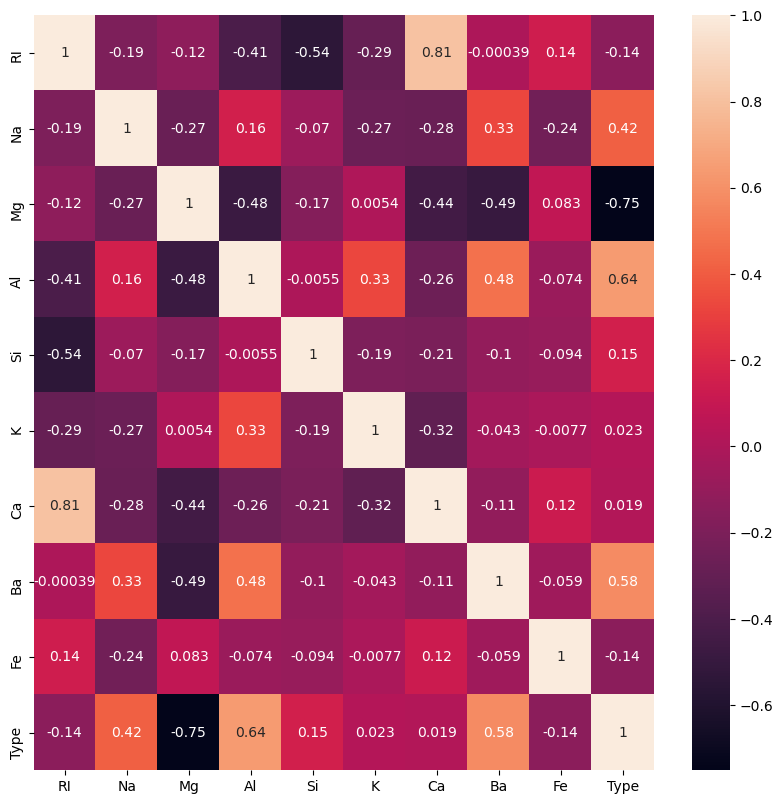

In [8]:
corr_heatmap = dataset.corr()
plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(corr_heatmap, annot=corr_heatmap)

### Wykresy zmiennych ###

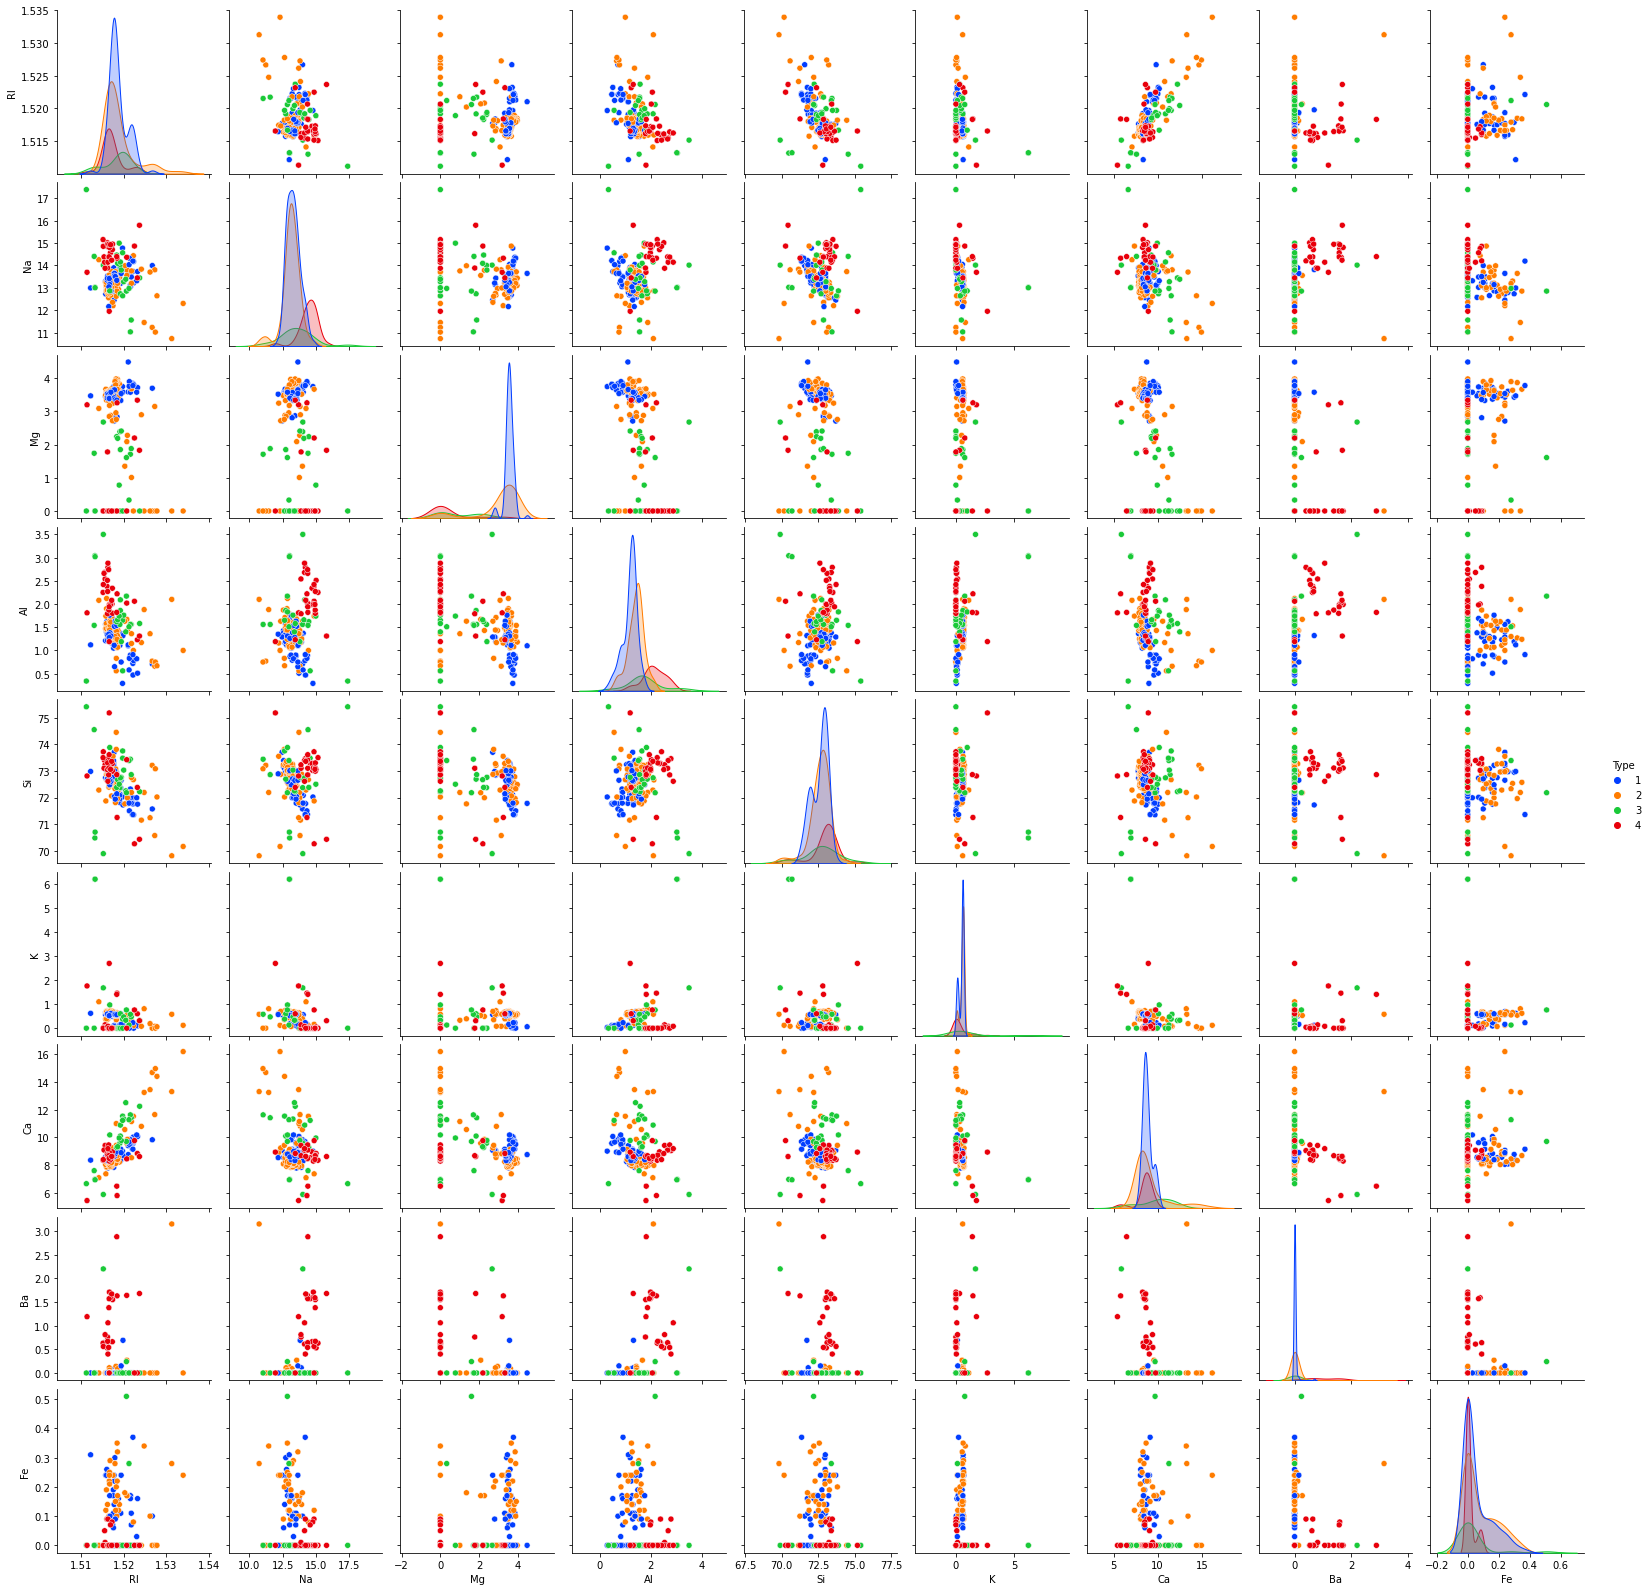

In [9]:
sns.pairplot(dataset, kind="scatter", hue="Type", palette="bright")
plt.show()

### Rozkład zmiennych ###

Już po analizie statystyk deskryptywnych można zauważyć że odległości maksymalne są zbyt oddalone od wartości mediany chociażby:
* dla zmiennej K mediana wynosi 0.55 podczas gdy wartość maksymalna 16.19 
* dla zmiennej Ba wszystkie 3 kwartyle wynoszą 0, podczas gdy wartość maksymalna wynosi 3.15
* dla zminnej Fe również min i mediana wynosi 0, a wartość maksymalna 0.51

Dodatkowo dla zmiennej Ba wszystkie 3 kwartyle są równe 0. Oznacza to, że zmienna ta dla większości obserwacji (ponad 75%) przyjmuje wartość 0. Jednocześnie jednak przy analizie wykresów klas w zależności od poszczególnych zmiennych można było zauważyć że zmienna Ba przyjmuje wartości większe niż 0 tylko dla 2 różnych klas. Jest to logiczne jeśli spojrzeć na charakter danych. Może sie tak zdarzyć że tylko pewien rodzaj szkła będzie zawierał dany pierwiastek. 

Pomocniczo wykonana została jeszcze analiza wykresów skośności. Skośność jest zbyt wysoka tzn. powyżej > 3 dla zmiennej Ba oraz K, co zgadza się z analizą statystyk deskryptywnych. Obrazuje to fakt, że dla większości zmiennych w zbiorze wartość średniej arytmetycznej nie odzwierciedla rzeczywistej tendencji centralnej rozkładu. W takim wypadku możemy podejrzewać istnienie wartości odstających w rozkładzie.

Zjawisko to jest jednak zrozumiałe jeśli spojrzeć na charakter danych, ale jednocześnie powoduje, że dane mają nieregularny rozkład.

In [10]:
dataset.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.00000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,1.96729
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,1.02726
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.00000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.00000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.00000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,2.00000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,4.00000


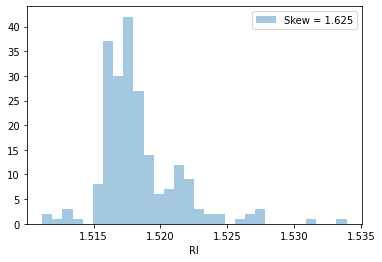

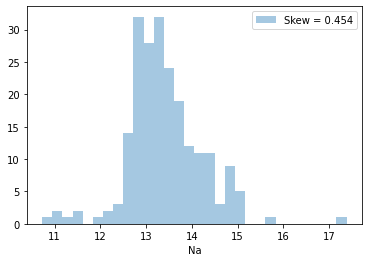

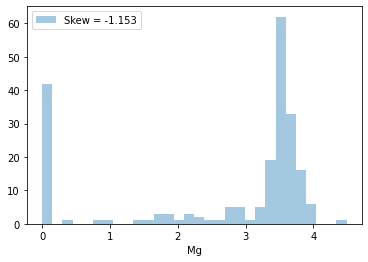

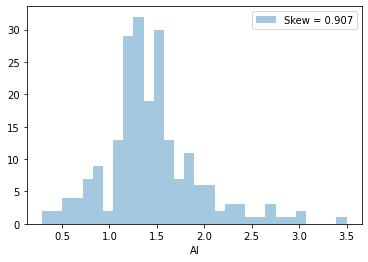

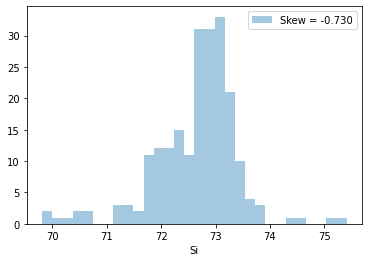

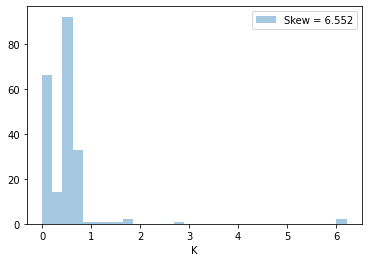

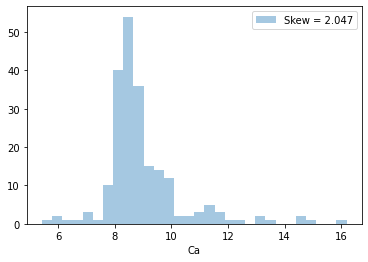

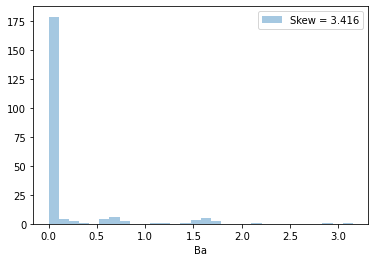

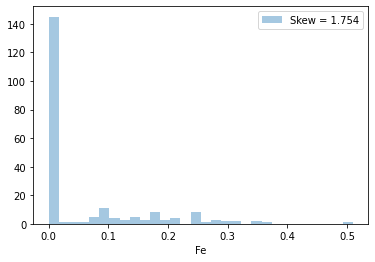

In [11]:
check_kurtosis(dataset)

## Czyszczenie zbioru ##

W poprzednim punkcie zaobserwowane zostały poniższe fakty:
* zmienne wapń oraz potas mają mały wpływ na atrybut decyzyjny
* dla baru oraz potasu rozkład charakteryzuje się silną skośnością i prawdopodobnie występują tam wartości odstające

Aby poradzić sobie z drugim problemem normalnie konieczna byłaby identyfikacja wartości odstających i usunięcie zawierających je obserwacji. W tym przypadku podejście to było by bardzo szkodliwe, bowiem te wartości odstające są prawdodobnie odwzorowaniem faktycznego składu pierwiastkowego poszczególnych typów szkła, nie wspominając już o fakcie że tylko zmniejszyło by to już i tak małoliczny zbiór danych.

Usunięte zostaną tylko niepotrzebne zmienne (mało skorelowane z atrybutem decyzyjnym). W innym przypadku można by użyć PCA (Principal Component Analysis) zamiast usunięcia zmiennych, nie jest ona jednak odporna na złe wyskalowanie danych.


In [12]:
dataset = dataset.drop(["Ca", "K"], axis=1)

## Sztuczne zwiększenie zbioru ##

Ponieważ zbiór ma nierównomierne rozmieszczenie obserwacji w klasach, co zaburza znacznie działanie większości klasyfikatorów, ponieważ będą one po prostu omijać klasę, która jest nie wystarczająco reprezentowana, aby uniknąć tego trzeba albo modyfikować obliczanie kosztu przez klasyfikator, albo w jakiś sposób wyrównać liczebność klas. W tym przypadku wybrano podejście drugie.

### Algorytm SMOTE ###

Technika syntetycznego odpróbkowania mniejszościowego (SMOTE) jest techniką statystyczną zwiększającą liczbę przypadków w zestawie danych w zrównoważony sposób. Algorytm działa w taki sposób, że generuje nowe obserwacje klas mniejszościowych na podstawie już istniejących, które podano jako dane wejściowe. Nowe wystąpienia nie są jedynie kopiami istniejących przypadków. Zamiast tego algorytm pobiera próbki przestrzeni funkcji dla każdej klasy docelowej i jej najbliższych sąsiadów. Następnie algorytm generuje nowe przykłady, które łączą funkcje przypadku docelowego z funkcjami jego sąsiadów.

Algorytm modyfikuje wszystkie klasy, których liczebność jest mniejsza niż klasy maksymalnej.

In [13]:
X = pd.DataFrame(dataset.drop(["Type"], axis=1))
Y = pd.DataFrame(dataset["Type"])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=1 / 4,
                                                    stratify=Y)

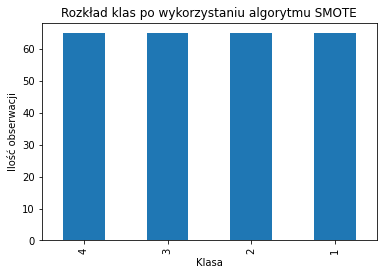

In [14]:
sm = SMOTE(random_state=42)
X_train_even, y_train_even = sm.fit_resample(X_train, y_train)
y_train_even = pd.DataFrame(y_train_even)
ax = y_train_even['Type'].value_counts().plot(kind="bar")
ax.set(xlabel="Klasa",
       ylabel="Ilość obserwacji",
       title="Rozkład klas po wykorzystaniu algorytmu SMOTE")

X_train = X_train_even
y_train = y_train_even

Sztuczne zwiększenie zbioru można zastosować jednak tylko do zbioru treningowego. Zbiór testowy musi zachować natomiast wyłącznie faktyczne obserwacje aby miał zastosowanie. Oznacza to, że część klas będzie występować w nim tylko w niewielu przypadkach.

In [15]:
y_test.value_counts()

Type
1       22
2       19
4        7
3        6
dtype: int64

## Klasyfikacja ##

Ponieważ nie można było zastosować skalowania danych, wybrany do klasyfikacji algorytm musi być odporny na nierówne zakresy wartości wśród zmiennych, ponieważ nie możemy zastosować normalizacji. Z tego powodu zastosowane zostanie drzewo decyzyjne. Skuteczność klasyfikacji będzie mierzona za pomocą miary oznaczającej odsetek poprawnych predykcji do ich całkowitej liczby, obliczanej na zbiorze testowym. 

In [16]:
def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Prawdziwe wartości')
    plt.xlabel('Otrzymane wartości')
    plt.tight_layout()

### Drzewo decyzyjne ###

W drzewach decyzyjnych jako klasyfikatorach w kolejnych krokach następuje  dzielenie zbioru poprzez odpowiedzi na pytania o wartości wybranych cech lub ich kombinacji liniowych. Hierarchiczność podejmowania decyzji jest cechą, która wyróżnia drzewo decyzyjne od innych metod. Drzewa decyzyjne stanowią dobry klasyfikator, gdy zawodzą metody tradycyjne, tzn. kiedy nie są spełnione wymogi dotyczące rozkładów, a to zostało zaobserwowane w przypadku analizowanego zbioru.

In [17]:
predictions = {}
for i in range(2, len(X_train.columns[:-1])):
    single_tree_test = tree.DecisionTreeClassifier(max_depth=i,
                                                   min_samples_split=10,
                                                   min_samples_leaf=5)
    single_tree_test.fit(X_train, y_train)
    predictions[i] = metrics.accuracy_score(y_test,
                                            single_tree_test.predict(X_test))
maxi = [
    i for i in range(2,
                     len(predictions) + 2)
    if predictions[i] == max(predictions.values())
]

# dla pierwszej głębokości z przedziału (2...liczba zmiennych) dającej najlepsze wyniki

single_tree = tree.DecisionTreeClassifier(max_depth=maxi[0])
single_tree.fit(X_train, y_train)
Y_hat = single_tree.predict(X_test)

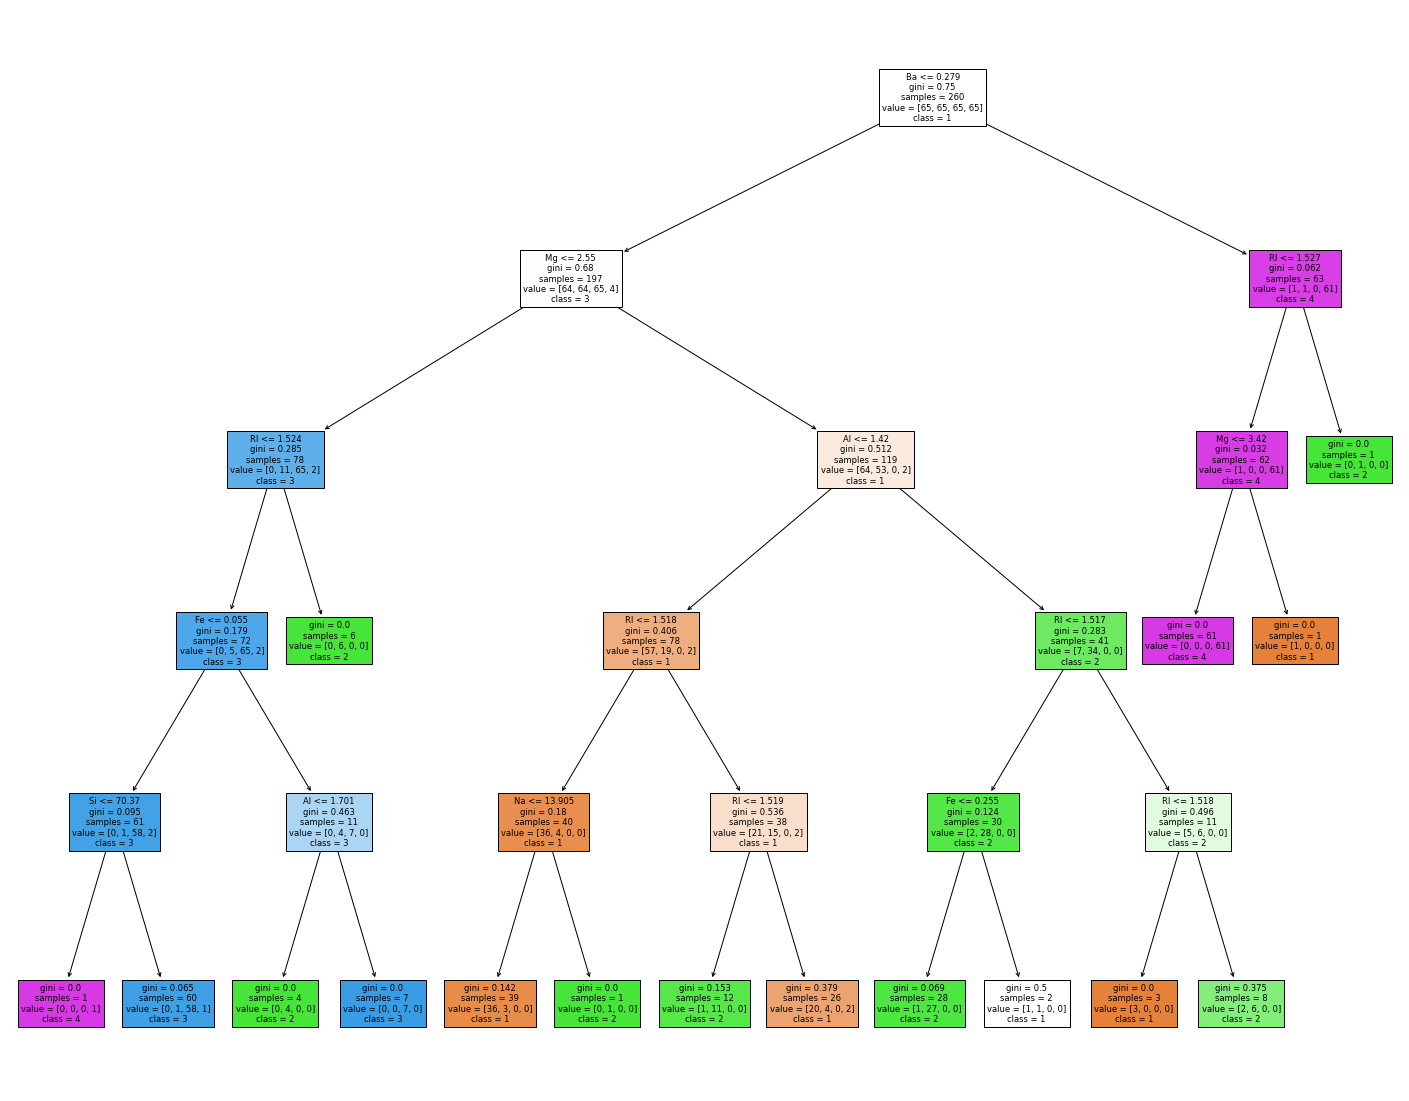

In [18]:
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(
    single_tree,
    feature_names=dataset.columns[:-1],
    class_names=[str(i) for i in dataset[dataset.columns[-1]].unique()],
    filled=True)

Accuracy = 0.833


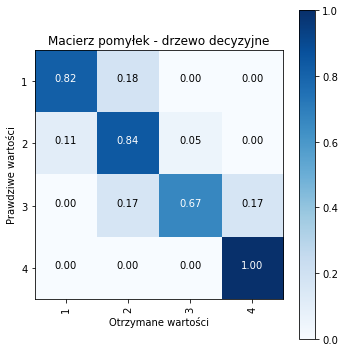

In [19]:
cm = metrics.confusion_matrix(y_test, Y_hat)

print("Accuracy =", round(metrics.accuracy_score(y_test, Y_hat), 3))
plot_confusion_matrix(cm,
                      classes=dataset[dataset.columns[-1]].unique(),
                      title='Macierz pomyłek - drzewo decyzyjne')

Jak widać powyżej powstałe drzewo składa się z aż 6 poziomów głębokości i kończy na 18 liściach. Do rozdzielenia obserwacji używa wszystkich zmiennych pozostałych w zbiorze. Drzewo wyszło dość głębokie, można by więc podejrzewać klasyfikator o zbyt nadmierne dopasowanie do danych treningowych. Porównam więc jeszcze wyniki na zbiorze testowym ze zbiorem drzew lasu losowego.

### Las losowy ###

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

Lasy losowe opierają się na tworzeniu dużej ilości drzew decyzyjnym i uśrednianiu ich wyniku. W przypadku klasyfikacji - przypisywania klasy wyznaczonej przez największą ilość drzew. Użyty zostaje dobór parametrów modelu spośród zbioru możliwych wartości. Bardzo ważnym elementem tworzenia lasu jest wybór cech każdego drzewa. W zwykłej próbie bootstrap drzewa wychodzą mocno skorelowane: jeśli jedna lub kilka cech jest bardzo silnymi predyktorami dla zmiennej odpowiedzi cechy te zostaną wybrane w wielu drzewach B. Dlatego każde drzewo musi wybierać cechy do tworzenia podziałów, tylko z podzbioru wszystkich możliwych cech.

Najlepsze wyniki zostają uzyskane z:
* maks. głębokością drzew - 8
* ilość cech branych pod uwagę przy budowie każdego drzewa - log2 łącznej liczby cech
* liczbą drzew użytych do budowy lasu - 300

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 300}
Accuracy = 0.852


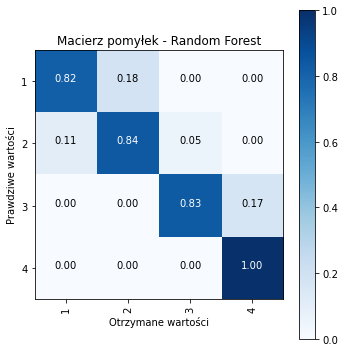

In [22]:
param_grid = {
    'n_estimators': [200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

rfc = RandomForestClassifier(min_samples_split=10, min_samples_leaf=5)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

print(CV_rfc.best_params_)

rfc = CV_rfc.best_estimator_
rfc.fit(X_train, y_train)
Y_hat = rfc.predict(X_test)
cm = metrics.confusion_matrix(y_test, Y_hat)

print("Accuracy =", round(metrics.accuracy_score(y_test, Y_hat), 3))
plot_confusion_matrix(cm,
                      classes=dataset[dataset.columns[-1]].unique(),
                      title='Macierz pomyłek - Random Forest')

### XGBOOST ###

XGBoost jest bazującym na drzewach, algorytmem wykorzystującym strukturę wzmacniającą gradient. W XGBOOST w każdym kolejnym kroku chcemy poprawić wcześniejsze błędy, dzięki czemu każde kolejne drzewo uczy się na błędach poprzednich w odróżnieniu od lasów losowych gdzie drzewa generowane są niezależnie od siebie. Aby to osiągnąć wykorzystuje technikę wzmacniania gradientu.

In [42]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
}

xgb = XGBClassifier()
CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)
CV_xgb.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], verbose=True)

xgb = CV_xgb.best_estimator_
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["merror", "mlogloss"],
        verbose=True)
Y_hat = xgb.predict(X_test)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
[0]	validation_0-merror:0.06154	validation_0-mlogloss:1.23687	validation_1-merror:0.20370	validation_1-mlogloss:1.26736
[1]	validation_0-merror:0.04615	validation_0-mlogloss:1.11213	validation_1-merror:0.20370	validation_1-mlogloss:1.17182
[2]	validation_0-merror:0.05769	validation_0-mlogloss:1.00853	validation_1-merror:0.24074	validation_1-mlogloss:1.09245
[3]	validation_0-merror:0.05000	validation_0-mlogloss:0.91749	validation_1-merror:0.22222	validation_1-mlogloss:1.02546
[4]	validation_0-merror:0.05000	validation_0-mlogloss:0.83826	validation_1-merror:0.22222	validation_1-mlogloss:0.96505
[5]	validation_0-merror:0.05000	validation_0-mlogloss:0.76876	validation_1-merror:0.20370	validation_1-mlogloss:0.91239
[6]	validation_0-merror:0.04231	validation_0-mlogloss:0.70707	validation_1-merror:0.22222	validation_1-mlogloss:0.87011
[7]	validation_0-merror:0.04231	validation_0-mlogloss:0.65063	validation_1-merror:0.16667	validation

[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.05607	validation_1-merror:0.14815	validation_1-mlogloss:0.52849
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.05479	validation_1-merror:0.14815	validation_1-mlogloss:0.52998
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.05362	validation_1-merror:0.14815	validation_1-mlogloss:0.53119
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.05263	validation_1-merror:0.12963	validation_1-mlogloss:0.53155
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.05163	validation_1-merror:0.12963	validation_1-mlogloss:0.53254
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.05065	validation_1-merror:0.12963	validation_1-mlogloss:0.53450
[74]	validation_0-merror:0.00000	validation_0-mlogloss:0.04965	validation_1-merror:0.12963	validation_1-mlogloss:0.53519
[75]	validation_0-merror:0.00000	validation_0-mlogloss:0.04854	validation_1-merror:0.14815	validation_1-mlogloss:0.53795
[76]	validation_0-merror:0.00000

[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.02352	validation_1-merror:0.16667	validation_1-mlogloss:0.58559
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.02336	validation_1-merror:0.16667	validation_1-mlogloss:0.58618
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.02320	validation_1-merror:0.16667	validation_1-mlogloss:0.58744
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.02300	validation_1-merror:0.16667	validation_1-mlogloss:0.58840
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.02285	validation_1-merror:0.16667	validation_1-mlogloss:0.58878
[141]	validation_0-merror:0.00000	validation_0-mlogloss:0.02271	validation_1-merror:0.16667	validation_1-mlogloss:0.58940
[142]	validation_0-merror:0.00000	validation_0-mlogloss:0.02254	validation_1-merror:0.16667	validation_1-mlogloss:0.58982
[143]	validation_0-merror:0.00000	validation_0-mlogloss:0.02241	validation_1-merror:0.16667	validation_1-mlogloss:0.59029
[144]	validation_0-merro

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Accuracy = 0.833


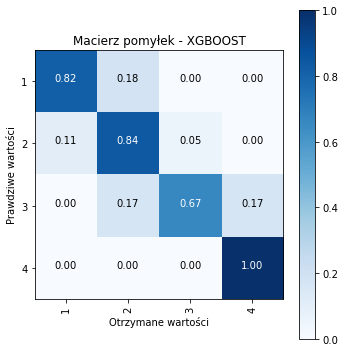

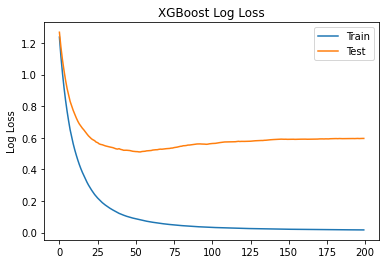

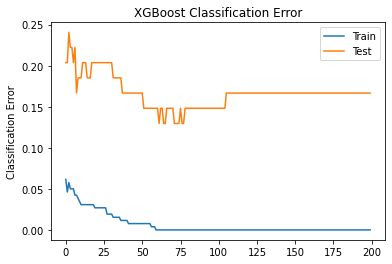

In [44]:
print(CV_xgb.best_params_)
cm = metrics.confusion_matrix(y_test, Y_hat)

print("Accuracy =", round(metrics.accuracy_score(y_test, Y_hat), 3))
plot_confusion_matrix(cm,
                      classes=dataset[dataset.columns[-1]].unique(),
                      title='Macierz pomyłek - XGBOOST')

results = xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [46]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=75)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["merror", "mlogloss"],
        verbose=True)
Y_hat = xgb.predict(X_test)

[0]	validation_0-merror:0.06154	validation_0-mlogloss:1.23687	validation_1-merror:0.20370	validation_1-mlogloss:1.26736
[1]	validation_0-merror:0.04615	validation_0-mlogloss:1.11213	validation_1-merror:0.20370	validation_1-mlogloss:1.17182
[2]	validation_0-merror:0.05769	validation_0-mlogloss:1.00853	validation_1-merror:0.24074	validation_1-mlogloss:1.09245
[3]	validation_0-merror:0.05000	validation_0-mlogloss:0.91749	validation_1-merror:0.22222	validation_1-mlogloss:1.02546
[4]	validation_0-merror:0.05000	validation_0-mlogloss:0.83826	validation_1-merror:0.22222	validation_1-mlogloss:0.96505
[5]	validation_0-merror:0.05000	validation_0-mlogloss:0.76876	validation_1-merror:0.20370	validation_1-mlogloss:0.91239
[6]	validation_0-merror:0.04231	validation_0-mlogloss:0.70707	validation_1-merror:0.22222	validation_1-mlogloss:0.87011
[7]	validation_0-merror:0.04231	validation_0-mlogloss:0.65063	validation_1-merror:0.16667	validation_1-mlogloss:0.83014
[8]	validation_0-merror:0.03846	validati

[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.05607	validation_1-merror:0.14815	validation_1-mlogloss:0.52849
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.05479	validation_1-merror:0.14815	validation_1-mlogloss:0.52998
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.05362	validation_1-merror:0.14815	validation_1-mlogloss:0.53119
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.05263	validation_1-merror:0.12963	validation_1-mlogloss:0.53155
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.05163	validation_1-merror:0.12963	validation_1-mlogloss:0.53254
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.05065	validation_1-merror:0.12963	validation_1-mlogloss:0.53450
[74]	validation_0-merror:0.00000	validation_0-mlogloss:0.04965	validation_1-merror:0.12963	validation_1-mlogloss:0.53519


Accuracy = 0.87


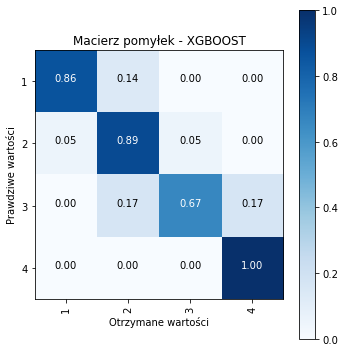

In [47]:
cm = metrics.confusion_matrix(y_test, Y_hat)

print("Accuracy =", round(metrics.accuracy_score(y_test, Y_hat), 3))
plot_confusion_matrix(cm,
                      classes=dataset[dataset.columns[-1]].unique(),
                      title='Macierz pomyłek - XGBOOST')

### Wnioski z klasyfikacji ###

Klasyfikacja była prowadzona w obrębie 4 klas:

* szkło płaskie - klasa 1
* szkło niepłaskie - klasa 2
* szkło do produkcji zastawy i pojemników - klasa 3
* szkło do produkcji reflektorów - klasa 4

Wyniki otrzymane poszczególnymi modelami:
* pojedyncze drzewo - 83%
* las losowy 85%
* XGBOOST 87%

Najlepszą dokładność klasyfikacji dla zbioru testowego zostaje uzyskany przy użyciu XGBOOSTa. Dzieje się
to jednak kosztem znacznie gorszej dokładności dla klasy 3  czyli szkła do produkcji zastawów i pojemników. Pojedyncze XGBOOST uzyskał dokładność 67%, las 83%. Pomimo, więc że za pomocą XGBOOSTA uzyskujemy nieco lepszą klasyfikację klasy 1 i 2, las losowy wydaje się w tym przypadku lepszym klasyfikatorem.


Najlepiej klasyfikowane były obserwacje ze zbioru testowego klasy 4 czyli szkła do produkcji reflektorów. Dokładność dla tej klasy wyniosła 100%. Może to prowadzić do konkluzji, że obserwacje tej klasy najbardziej różnią się jeśli chodzi o cechy od klas pozostałych.



## Podsumowanie wyników ##

Analiza powyższych danych, była ograniczona z powodu małej wielkości próby. Uzyskano 85% trafności klasyfikacji przy użyciu lasu loswego.
Ze względu na nieregularność rozkładów niektórych składów pierwiastkowych, nie była możliwa normalizacja danych, a to uniemożliwiało również wypróbowanie większej ilości klasyfikatorów, bowiem niewiele z nich jest odpornych na nierównomierność rozkładów.

## Źródła ##

Dane i informacje o zbiorze:
1. https://archive.ics.uci.edu/ml/datasets/Glass+Identification
2. https://www.kaggle.com/uciml/glass

Analizowane wcześniejsze podejścia do problemu:
1. https://www.kaggle.com/eliekawerk/glass-type-classification-with-machine-learning
2. https://www.kaggle.com/landonv123/high-accuracy-knn-pca-and-oversampling-smote-93

Algorytmy:
1. https://machinelearningmastery.com/imbalanced-classification-is-hard/
2. https://docs.microsoft.com/pl-pl/azure/machine-learning/algorithm-module-reference/smote
3. https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/